In [1]:
from qibo.gates import I, X, RX, RY, M, CZ, Y, Z
import numpy as np
from qibo.models import Circuit
from itertools import product

from utils.qst_qpt_helper_functions import *

from qiboconnection.api import API
from qiboconnection.connection import ConnectionConfiguration

import datetime

api = API(ConnectionConfiguration(username="qat", api_key="meow"))


api.select_device_id(9)

#### Constants

In [2]:
NUM_SHOTS = 1000

#### Define basic gate sequence

In [3]:
def six_operators(qubit):
    return [
        I(qubit),
        X(qubit),
        RX(qubit, np.pi / 2),
        RX(qubit, -np.pi / 2),
        RY(qubit, np.pi / 2),
        RY(qubit, -np.pi / 2),
    ]

#### Define circuits for process tomography of the CZ gate and for obtaining the SPAM matrix

In [4]:
def process_tomography(pa, qubit_a, qubit_b):
    """Returns tomography circuits for the 6 different states in qubit B.

    Args:
        pa (qibo.gates.gates): gate assigning the preparation of qubit A.
        qubit_a (int_): first qubit
        qubit_b (int): second qubit

    Returns:
        circuits: list containing the generated tomography circuits.
    """
    circuits = []

    for pb in six_operators(qubit_b):
        for op1_a in six_operators(qubit_a):
            for op1_b in six_operators(qubit_b):
                circuit = Circuit(5)
                circuit.add(pa)  # PA
                circuit.add(pb)  # PB
                circuit.add(CZ(qubit_a, qubit_b))
                circuit.add(op1_a)  # RA
                circuit.add(op1_b)  # RB
                circuit.add(M(qubit_a, qubit_b))

                circuits.append(circuit)
    return circuits


def spam_matrix_circuits(qubit_a, qubit_b):
    circuits = []
    for gate_a in [I, X]:
        for gate_b in [I, X]:
            circuit = Circuit(5)
            circuit.add(gate_a(qubit_a))
            circuit.add(gate_b(qubit_b))
            circuit.add(M(qubit_a, qubit_b))

            circuits.append(circuit)

    return circuits

#### Run sequences
We separate the data coming from each post-CZ basis state reconstruction in order to go around the 1000 circuit limit per execute call.

In [5]:
qubit_pairs = [(0, 2), (1, 2), (2, 3), (2, 4)]

spam_job_ids = {}
qpt_job_ids = {}

import os

os.environ["QIBOCONNECTION_TIMEOUT"] = "30"
## Las dos líneas anteriores es si esta celda me da un error de read timeout, que puede ser porque la red del IFAE esté
## más lenta de lo normal. Default was 10 instead of 30.

for qubit_pair in qubit_pairs:
    QUBIT_A, QUBIT_B = qubit_pair

    ## Run SPAM measurements, store ID
    spam_circuits = spam_matrix_circuits(QUBIT_A, QUBIT_B)
    result_id = api.execute(spam_circuits, nshots=NUM_SHOTS)[0]
    spam_job_ids[str(qubit_pair)] = result_id

    qst_jobids = {}

    ## Run QPT measurements, store ID
    for i, pa in enumerate(six_operators(QUBIT_A)):
        state_tomography_circuits = process_tomography(pa, QUBIT_A, QUBIT_B)
        result_id = api.execute(state_tomography_circuits, nshots=NUM_SHOTS)[0]

        qst_jobids[str(i)] = result_id

    qpt_job_ids[str(qubit_pair)] = qst_jobids

#### Save job ids in .txt

In [6]:
today = datetime.datetime.now()
date_stamp = ("").join([str(x) for x in [today.year, today.month, today.day]])
time_stamp = ("").join([str(x) for x in [today.hour, today.minute, today.second]])
fpath_saveids = f"./qpt_job_ids_{date_stamp}_{time_stamp}.txt"
print("saved IDs in", fpath_saveids)

## actually save IDs
with open(fpath_saveids, "w") as f:
    for qubit_pair in qubit_pairs:
        f.write("####" + str(qubit_pair) + "\n")
        f.write("spam" + "\t" + str(spam_job_ids[str(qubit_pair)]) + "\n")

        f.write("qpt" + "\t")
        for x in qpt_job_ids[str(qubit_pair)].values():
            f.write(str(x) + "\t")
        f.write("\n")

saved IDs in ./qpt_job_ids_20231219_221944.txt


#### Retrieve jobs from .txt

In [5]:
fpath_saveids = "./qpt_job_ids_20231213_122521.txt"

In [6]:
def retrieve_jobids(fpath_saveids):
    spam_job_ids = {}
    qpt_job_ids = {}
    with open(fpath_saveids, "r") as f:
        for line in f.readlines():
            if line[:4] == "####":
                qubit_pair = (int(line[5]), int(line[8]))
            elif line[:4] == "spam":
                spam_job_ids[str(qubit_pair)] = int(line[5:-1])
            elif line[:3] == "qpt":
                qst_jobids = {}
                for i, x in enumerate(line.split("\t")[1:-1]):
                    qst_jobids[str(i)] = int(x)
                qpt_job_ids[str(qubit_pair)] = qst_jobids
    return spam_job_ids, qpt_job_ids


spam_job_ids, qpt_job_ids = retrieve_jobids(fpath_saveids)

In [7]:
# api.list_jobs().dataframe[:40]

### Analyse data

In [8]:
qubit_pairs = [(0, 2), (1, 2), (2, 3), (2, 4)]

state_reconstruction_paulibasis = np.zeros((len(qubit_pairs), 36, 16))

ideal_operator = CZ(0, 1).matrix
R_ideal = get_ideal_R_matrix(ideal_operator)

reconstructed_Rs = np.zeros((len(qubit_pairs), 16, 16))
fidelities = {}


for pair_index, qubit_pair in enumerate(qubit_pairs):
    spam_id = spam_job_ids[str(qubit_pair)]
    spam_results = api.get_result(spam_id)
    spam_data_probabilities = process_returned_dataformat(spam_results, nqubits=2)
    coeffs_mat_spam, ideal_measurements_spam = prepare_linear_system_measurement_calibration(spam_data_probabilities)
    measurement_calibration_weights = np.linalg.solve(coeffs_mat_spam, ideal_measurements_spam).reshape(3, 4)
    measurement_calibration_weights = np.linalg.pinv(measurement_calibration_weights)

    P_index = 0
    for pa_index in range(6):
        qst_pa_id = qpt_job_ids[str(qubit_pair)][str(pa_index)]
        qst_pa_results = api.get_result(qst_pa_id)
        qst_pa_probabilities = process_returned_dataformat(qst_pa_results, nqubits=2)
        qst_pa_expectedobs = convert_probabilities2measurementops(qst_pa_probabilities)

        for pb_index in range(6):
            qst_papb_expectedobs = qst_pa_expectedobs[pb_index * 36 : 36 * (pb_index + 1)]
            coeff_matrix, independent_term = prepare_linear_system_QST(
                measurement_calibration_weights, qst_papb_expectedobs
            )

            ## solve linear system QST
            reconstructed_state_paulibasis_noII = np.linalg.pinv(coeff_matrix) @ independent_term
            state_reconstruction_paulibasis[pair_index, P_index] = np.append(1 / 4, reconstructed_state_paulibasis_noII)

            P_index += 1

    coeffs_mat, independent_term = prepare_linear_system_QPT(state_reconstruction_paulibasis[pair_index])
    Rvec = np.linalg.pinv(coeffs_mat) @ independent_term
    reconstructed_R = Rvec.reshape(16, 16)
    reconstructed_Rs[pair_index] = reconstructed_R

    process_fidelity = compute_process_fidelity(R_ideal, reconstructed_R)
    fidelities[str(qubit_pair)] = process_fidelity

[Qibo 0.1.12.dev0|INFO|2023-12-14 11:04:11]: Using numpy backend on /CPU:0


Your job with id 7055 is completed.
Your job with id 7056 is completed.
Your job with id 7057 is completed.
Your job with id 7058 is completed.
Your job with id 7059 is completed.
Your job with id 7060 is completed.
Your job with id 7061 is completed.
Your job with id 7062 is completed.
Your job with id 7063 is completed.
Your job with id 7064 is completed.
Your job with id 7065 is completed.
Your job with id 7066 is completed.
Your job with id 7067 is completed.
Your job with id 7068 is completed.
Your job with id 7069 is completed.
Your job with id 7070 is completed.
Your job with id 7071 is completed.
Your job with id 7072 is completed.
Your job with id 7073 is completed.
Your job with id 7074 is completed.
Your job with id 7075 is completed.
Your job with id 7076 is completed.
Your job with id 7077 is completed.
Your job with id 7078 is completed.
Your job with id 7079 is completed.
Your job with id 7080 is completed.
Your job with id 7081 is completed.
Your job with id 7082 is com

In [9]:
print(fidelities)

{'(0, 2)': 0.8750861572369482, '(1, 2)': 0.8100477593758857, '(2, 3)': 0.8125987419263887, '(2, 4)': 0.8724082454312923}


In [10]:
import matplotlib.pyplot as plt
from seaborn import heatmap
from pandas import DataFrame

In [11]:
def plot_R(R_mat, title=None, ax=None, fig=None):
    xlabels = ["II", "IX", "IY", "IZ", "XI", "XX", "XY", "XZ", "YI", "YX", "YY", "YZ", "ZI", "ZX", "ZY", "ZZ"]

    r_df = DataFrame(R_mat * (2**2), index=xlabels, columns=xlabels)
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 3))
    ax = heatmap(r_df, vmin=-4, vmax=4, ax=ax)
    if title is not None:
        ax.set_title(title)
    return fig, ax

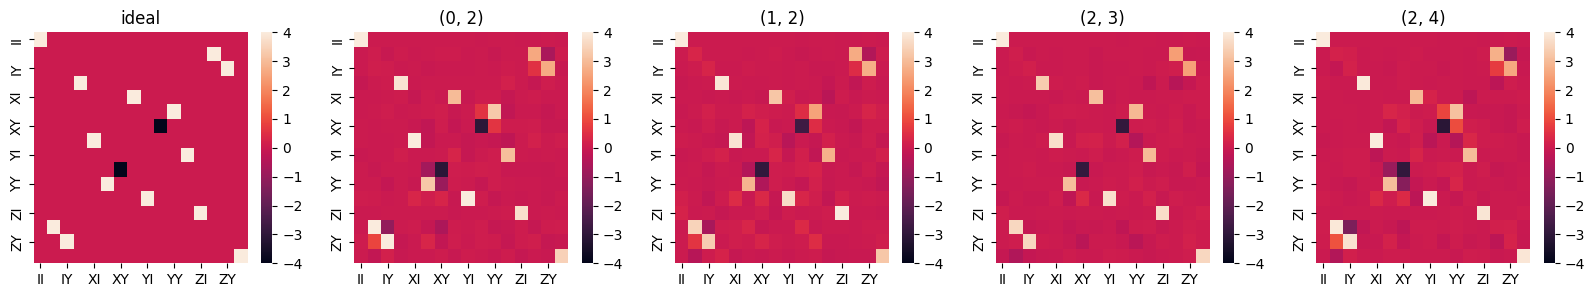

In [12]:
figsize = (3, 3)
fig, axes = plt.subplots(1, 5, figsize=(20, 3))
fig, axes[0] = plot_R(R_ideal, title="ideal", ax=axes[0], fig=fig)
for i in range(4):
    fig, axes[i + 1] = plot_R(reconstructed_Rs[i], title=str(qubit_pairs[i]), ax=axes[i + 1])